<a href="https://colab.research.google.com/github/dookda/gisnorth_openhouse/blob/main/roof_detection_theos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install python package
!pip install pandas numpy matplotlib seaborn pytest-warnings PyYAML random Pillow opencv-python
!pip install ultralytics
!pip install geopandas
!pip install rasterio
!pip install shapely
!pip install pyproj
!pip install folium
!pip install ipyleaflet

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!cp "/content/drive/MyDrive/_DATASET/tms_to_geotiff.py" /content/
!cp "/content/drive/MyDrive/_DATASET/model_Google.pt" /content/
!cp "/content/drive/MyDrive/_DATASET/theos/theos2_3857.tif" /content/


!ls -l /content/tms_to_geotiff.py /content/model_Google.pt

-rw------- 1 root root 143995848 Aug 13 00:15 /content/model_Google.pt
-rw------- 1 root root     11577 Aug 13 00:15 /content/tms_to_geotiff.py


In [ ]:
import os
import shutil
import torch
from tms_to_geotiff import tms_to_geotiff
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
import rasterio
from rasterio.features import shapes
from shapely.geometry import shape, mapping
import geopandas as gpd
import pandas as pd
import numpy as np
from datetime import datetime
import shutil

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from ipyleaflet import Map, DrawControl, TileLayer
from datetime import datetime

# 2. declare a global to hold the bbox
bbox = None

# 3. create the map
m = Map(center=(18.79, 98.98), zoom=16)

google_sat = TileLayer(
    url='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
    attribution='Map data © Google'
)
m.add_layer(google_sat)

# 4. add only rectangle draw tools
dc = DrawControl(
    rectangle={"shapeOptions": {"color": "#ff0000"}},
    polygon={}, polyline={}, circle={}, marker={}, circlemarker={}
)
dc.edit = False

# 5. callback writes into the global `bbox`
def handle_draw(target, action, geo_json):
    global bbox
    coords = geo_json["geometry"]["coordinates"][0]
    lons = [pt[0] for pt in coords]
    lats = [pt[1] for pt in coords]
    bbox = (min(lons), min(lats), max(lons), max(lats))
    print(f"[west, south, east, north] = {bbox}  @ {datetime.now()}")

dc.on_draw(handle_draw)

# 6. attach and display
m.add_control(dc)
m


Map(center=[18.79, 98.98], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

[west, south, east, north] = (98.978684, 18.787002, 98.987889, 18.79269)  @ 2025-08-12 23:57:26.301894


In [ ]:
print(list(bbox))
bbox = list(bbox)
image = 'satellite.tif'
tms_to_geotiff(output=image, bbox=bbox, zoom=20, source='Satellite', overwrite=True)

Image saved to satellite.tif


In [ ]:
import folium
from folium.raster_layers import ImageOverlay
# from folium.tile_layer import TileLayer # Removed the incorrect import
from folium import TileLayer # Added the correct import


# Re-using the map object 'm' created in cell a2PJEeftDgPy
# Load the GeoTIFF file
with rasterio.open('satellite.tif') as src:
    bounds = [src.bounds.bottom, src.bounds.left, src.bounds.top, src.bounds.right]
    image_data = src.read(1)  # Read the first band

# Add the GeoTIFF as an image overlay to the map
f = folium.Figure(height=400)
m = folium.Map(
    zoom_start=24,
).add_to(f)

# Add the base map with a specified name
TileLayer(
    tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
    max_zoom=24,
    attr='Google Satellite',
    name='Google Satellite'
).add_to(m)

# img_overlay = ImageOverlay(
#     image_data,
#     bounds=bounds,
#     colormap=lambda x: plt.cm.gray(x),
#     opacity=0.7,
#     name='Satellite Image Overlay'
# )

# img_overlay.add_to(m)

# Add layer control to toggle the image overlay
folium.LayerControl().add_to(m)

# Display the map
m

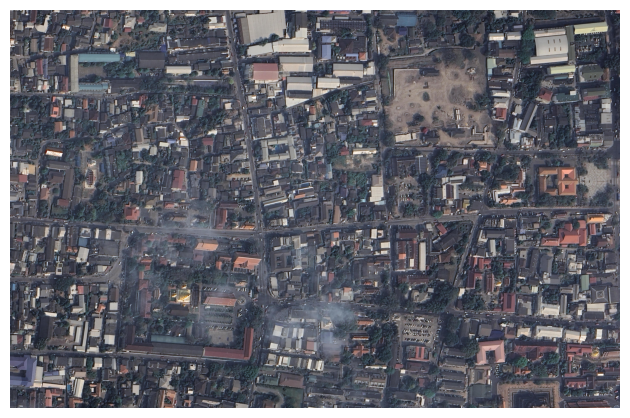

In [ ]:
# show image
image = cv2.imread(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.axis('off')
plt.tight_layout()
plt.show()


image 1/1 /content/satellite.tif: 448x640 220 Cement Roofs, 1 Concrete roof, 14 Metal roofs, 5267.5ms
Speed: 7.4ms preprocess, 5267.5ms inference, 1201.2ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs/segment/predict2


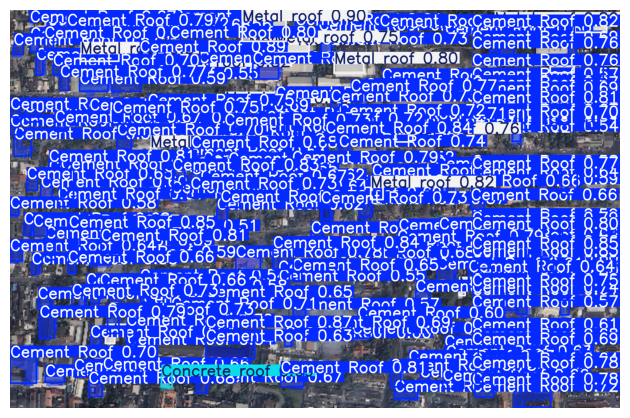

In [ ]:
# Load a pretrained model
model = YOLO("model_Google.pt")

# Run inference on 'bus.jpg' with arguments
results = model.predict("satellite.tif", save=True, imgsz=640, conf=0.5)
# results = bestModel.predict(source=imagePath, imgsz=640)

annotatedImage = results[0].plot()
annotatedImageRGB = cv2.cvtColor(annotatedImage, cv2.COLOR_BGR2RGB)
plt.imshow(annotatedImageRGB)
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
import os
import shutil
import torch
from tms_to_geotiff import tms_to_geotiff
from ultralytics import YOLO
import rasterio
from rasterio.features import shapes
from shapely.geometry import shape
import geopandas as gpd
import pandas as pd
from datetime import datetime
import folium
from IPython.display import display, HTML

def roofdetect(image):

    model = YOLO("model_Google.pt")
    results = model.predict(image, save=True, imgsz=640, conf=0.5)

    with rasterio.open(image) as src:
        transform = src.transform
        crs = src.crs
        height, width = src.height, src.width

    gdfs = []
    for i, mask in enumerate(results[0].masks.data):
        mask = mask.cpu().numpy().astype('uint8')
        class_index = int(results[0].boxes.cls[i])
        label = results[0].names[class_index]

        output_file = f"segment_{i+1}.tif"
        with rasterio.open(
            output_file,
            "w",
            driver="GTiff",
            height=height,
            width=width,
            count=1,
            dtype=mask.dtype,
            crs=crs,
            transform=transform,
        ) as dst:
            dst.write(mask, 1)

        with rasterio.open(output_file) as src:
            mask_data = src.read(1)
            shapes_gen = shapes(mask_data, transform=src.transform)
            polygons = [shape(geom) for geom, val in shapes_gen if val == 1]
            gdf = gpd.GeoDataFrame(geometry=polygons, crs=crs)
            gdf['label'] = label
            gdfs.append(gdf)
        os.remove(output_file)

    combined_gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True))
    combined_gdf = combined_gdf.to_crs('EPSG:4326')

    f = folium.Figure(height=400)
    m = folium.Map(
        location=[(bbox[1] + bbox[3])/2, (bbox[0] + bbox[2])/2],
        zoom_start=24,
        max_zoom=24,
        tiles='https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr='Google Satellite'
    ).add_to(f)

    # Add detection polygons
    folium.GeoJson(
        combined_gdf,
        name='Roof Detections',
        style_function=lambda x: {
            'color': 'red',
            'weight': 2,
            'fillColor': 'red',
            'fillOpacity': 0.4
        }
    ).add_to(m)
    # display(m)
    m
    if os.path.exists('runs'):
        shutil.rmtree('runs')

if __name__ == '__main__':
    image = 'theos2_20240513_3857.tif'
    roofdetect(image)

RuntimeError: Given groups=1, weight of size [80, 3, 3, 3], expected input[1, 1, 608, 640] to have 3 channels, but got 1 channels instead